## Use 4 selected weather stations to predict one given (Pärnu) weather station

## Loading data and converting to dataframe

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import datetime
import sklearn

### Solar intensity data

In [40]:
#Load initial data
hourly_sun_intensity = pd.read_excel('2-10_21_524-2 Andmed.xlsx', sheet_name = 'tunni sum.kiirgus', header = 1)

In [41]:
#Update column names by shortening them and converting to English
newColumnNames = dict()
newColumnNames["Aasta"] = "y"
newColumnNames["Kuu"] = "m"
newColumnNames["Päaev"] = "d"
newColumnNames["Kell (UTC)"] = "time"
for columnName in hourly_sun_intensity.columns:
    if "kiirgus" in columnName:
        newColumnNames[columnName] = "solar_"+columnName.replace(" summaarne kiirgus, W/m²", "")
hourly_sun_intensity = hourly_sun_intensity.rename(columns=newColumnNames)

In [42]:
# Some weather stations have changed locations over time, as the differences between their locations are rather small (less than 8 km)
# We at first do not make separation between them

def join_columns(c1, c2, nc, df, column_id): # Function for joining columns, where an area has two weather measuring points
    data = []
    cs = [c1, c2]
    for i, rows in df[cs].iterrows():
        if (pd.isna(rows[0]) == True) & (pd.isna(rows[1]) == False):
            data.append(round(rows[1], 2))
        elif (pd.isna(rows[0]) == False) & (pd.isna(rows[1]) == True):
            data.append(round(rows[0], 2))
        elif (pd.isna(rows[0]) == False) & (pd.isna(rows[1]) == False):
            data.append(round(rows.mean(), 2))
        elif (pd.isna(rows[0]) == True) & (pd.isna(rows[1]) == True):
            data.append(rows[0])

    df = df.drop(columns = [c1, c2])
    df.insert(column_id, nc, data)
    
    return df

In [43]:
#Merge columns, which are due to weather station moving
hourly_sun_intensity = join_columns('solar_Narva', 'solar_Narva-Jõesuu', 'solar_Narva', hourly_sun_intensity, 4)
hourly_sun_intensity = join_columns('solar_Pärnu-Sauga', 'solar_Pärnu', 'solar_Pärnu', hourly_sun_intensity, 5)

In [44]:
#Drop rows where some value is missing
hourly_sun_intensity = hourly_sun_intensity.dropna()
#If value is -1 it corresponds to night, set it to 0
hourly_sun_intensity = hourly_sun_intensity.replace(-1, 0)

In [45]:
#Shift the times -X minutes to facilitate predicting future solar intensity from existing
def shiftDateTime(df, numberOfHours):
    dateTimes = []
    for i in range(len(df)):
        row = df.iloc[i]
        dateTimes+=[datetime.datetime.combine(datetime.date(row.y, row.m, row.d), row.time)+datetime.timedelta(hours=numberOfHours)]
    df2 = copy.deepcopy(df)
    df2["y"] = [date.year for date in dateTimes]
    df2["m"] = [date.month for date in dateTimes]
    df2["d"] = [date.day for date in dateTimes]
    df2["time"] = [date.time() for date in dateTimes]
    
    return df2
    
    

In [46]:
hourly_sun_intensity_Shifted = shiftDateTime(hourly_sun_intensity, -1)

### Data from different weather stations

#### Locations


Tallinn-Harku
Laius: N 59°23´53´´
Pikkus: E 24°36´10´´
Decimal
Lat: 59.398055
Long: 24.602778


Haapsalu meteoroloogiajaam
Laius N 58°56´40´´
Pikkus E 23°33´18´´
Decimal
Lat: 58.944444
Long: 23.555

Narva
Laius: N 59°23´22´´
Pikkus: E 28°06´33´´
Decimal
Lat: 59.389444
Long: 28.109167

Pärnu
Laius: N 58°23´4,44´´
Pikkus: E 24°29´6,71´´
Decimal
Lat: 58.384556
Long: 24.485197

Roomassaare
Laius: N 58°13’05”
Pikkus: E 22°30’23”
Decimal
Lat: 58.218056 
Long: 22.506389 

Tartu-Tõravere meteoroloogiajaam
Laius: N 58°15´51´´
Pikkus: E 26°27´41´
Decimal
Lat: 58.264167
Long: 26.461389

Tiirikoja järvejaam
Laius: N 58°51´55´´
Pikkus: E 26°57´08´´
Decimal
Lat: 58.865278
Long: 26.952222

Vilsandi rannikujaam
Laius: N 58°22´58”
Pikkus: E 21°48´51”
Deciaml
Lat: 58.382778
Long: 21.814167

In [47]:
weather_station_coordinates = dict()
weather_station_coordinates["tallinn"] = [59.398055, 24.602778]
weather_station_coordinates["haapsalu"] = [58.944444, 23.555]
weather_station_coordinates["narva"] = [59.389444, 28.109167]
weather_station_coordinates["parnu"] = [59.389444, 28.109167]
weather_station_coordinates["roomassaare"] = [58.218056, 22.506389]
weather_station_coordinates["tartu"] = [58.264167, 26.461389]
weather_station_coordinates["tiirikoja"] = [58.865278, 26.952222]
weather_station_coordinates["vilsandi"] = [58.382778, 21.814167]

In [48]:
selectedColumns = ["Aasta", "Kuu", "Päev", "Kell (UTC)", "Õhutemperatuur °C","Suhteline õhuniiskus %", "10 minuti keskmine tuule kiirus m/s", "10 minuti keskmine tuule suund"]

In [49]:
#Update column names by shortening them and converting to English

def updateColumnNames(df, location):
    newColumnNames = dict()
    newColumnNames["Aasta"] = "y"
    newColumnNames["Kuu"] = "m"
    newColumnNames["Päev"] = "d"
    newColumnNames["Kell (UTC)"] = "time"
    newColumnNames["Õhutemperatuur °C"] = f"temp_{location}"
    newColumnNames["10 minuti keskmine tuule kiirus m/s"] = f"wind_speed_{location}"
    newColumnNames["Õhurõhk jaama kõrgusel hPa"] = f"pressure_{location}"
    newColumnNames["Suhteline õhuniiskus %"] = f"rel_humidity_{location}"
    newColumnNames["10 minuti keskmine tuule suund"] = f"wind_dir_{location}"
    df = df.rename(columns=newColumnNames)
    return df

In [50]:
def getFromXlsx(filename, columns, location):
    #Load xlsx
    df = pd.read_excel(filename, header = 1)
    df = df[columns]
    #Drop rows where data is missing
    #df = df.dropna()
    #Update column names for clarity
    df = updateColumnNames(df, location)
    return df

In [51]:
#Get Tallinn
data_tallinn = getFromXlsx("./data/Tallinn-Harku_2004-2020.xlsx", selectedColumns, "tallinn")
#Get Roomassaare
data_roomassaare = getFromXlsx("./data/Roomassaare_2008-2020.xlsx", selectedColumns, "roomassaare")
#Merge tables
data_weather = data_tallinn.merge(data_roomassaare, how='left', on=["y", "m", "d", "time"])

In [52]:
#Get Vilsandi
data_vilsandi = getFromXlsx("./data/Vilsandi_2004-2020.xlsx", selectedColumns, "vilsandi")
#Merge tables
data_weather = data_weather.merge(data_vilsandi, how='left', on=["y", "m", "d", "time"])

In [54]:
data_Tartu = getFromXlsx("./data/Tartu-Toravere_2004-2020.xlsx", selectedColumns, "tartu")
#Merge tables

data_weather = data_weather.merge(data_Tartu, how='left', on=["y", "m", "d", "time"])


In [55]:
data_Narva = getFromXlsx("./data/Narva_19.12.2013-2020.xlsx", selectedColumns, "narva")
data_weather = data_weather.merge(data_Narva, how='left', on=["y", "m", "d", "time"])

In [56]:
#Once again drop all rows where some row is missing
data_weather = data_weather.dropna()

### Join weather and solar data

In [57]:
data_solar_weather = hourly_sun_intensity_Shifted.merge(data_weather, how='left', on=["y", "m", "d", "time"])

In [58]:
hours = []
for i in range(len(data_solar_weather)):
    hours+=[data_solar_weather.iloc[i].time.hour]
data_solar_weather["h"] = hours


In [59]:
data_solar_weather = data_solar_weather.dropna()

In [60]:
data_solar_weather.columns

Index(['y', 'm', 'd', 'time', 'solar_Narva', 'solar_Pärnu', 'solar_Haapsalu',
       'solar_Tallinn-Harku', 'solar_Roomassaare', 'solar_Tartu-Tõravere',
       'solar_Tiirikoja', 'solar_Vilsandi', 'temp_tallinn',
       'rel_humidity_tallinn', 'wind_speed_tallinn', 'wind_dir_tallinn',
       'temp_roomassaare', 'rel_humidity_roomassaare',
       'wind_speed_roomassaare', 'wind_dir_roomassaare', 'temp_vilsandi',
       'rel_humidity_vilsandi', 'wind_speed_vilsandi', 'wind_dir_vilsandi',
       'temp_tartu', 'rel_humidity_tartu', 'wind_speed_tartu',
       'wind_dir_tartu', 'temp_narva', 'rel_humidity_narva',
       'wind_speed_narva', 'wind_dir_narva', 'h'],
      dtype='object')

## 4 other stations, predict Pärnu, different parameters

4 Stations Tartu, Tallinn, Roomassaare, Vilsandi, predict Pärnu
dtr 96.26316991627043
rf 66.69709972042308


### Variables in Data

In [23]:
data_solar_weather.columns

Index(['y', 'm', 'd', 'time', 'solar_Narva', 'solar_Pärnu', 'solar_Haapsalu',
       'solar_Tallinn-Harku', 'solar_Roomassaare', 'solar_Tartu-Tõravere',
       'solar_Tiirikoja', 'solar_Vilsandi', 'temp_tallinn',
       'rel_humidity_tallinn', 'wind_speed_tallinn', 'wind_dir_tallinn',
       'temp_roomassaare', 'rel_humidity_roomassaare',
       'wind_speed_roomassaare', 'wind_dir_roomassaare', 'temp_vilsandi',
       'rel_humidity_vilsandi', 'wind_speed_vilsandi', 'wind_dir_vilsandi',
       'temp_tartu', 'rel_humidity_tartu', 'wind_speed_tartu',
       'wind_dir_tartu', 'temp_narva', 'rel_humidity_narva',
       'wind_speed_narva', 'wind_dir_narva', 'h'],
      dtype='object')

#### Our implementation of backward feature selection algorithm: 

- Split the data into train set and test set
- Train full model on train set
    - Get full model performance on test set
- Start leave one out procedure
    - Train individual models with one certain feature left out based on train set
    - Score model performance based on CV = 5 average performance on train set 
    - Delete the left out feature related to best performing model
    - Assess performance on test set based on model related to best set selected in previous step
    - Repeat until specified min number of features is reached
- Stopping rule:
    - Starting from full model move backwards in series of test scores until the point of decreasing performance is reached

#### We also implemented forward feature selection algorithm:

- Similar as previous model
- Starting from one feature dataset, continues adding features based on best train performance 
- Cutoff implemented from the beginning 


#### Forward selection algorithm implemntation - not used

In [ ]:
## Feature selection for one model 

# Defining forward selection algorithm 

from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.metrics import mean_squared_error

def forward_selector(maxFeatureN, train_y, test_y, train_X, test_X, random_seed, cv_k, originalData, 
                     isPandas = False):
    
    np.random.seed(random_seed)
    
    returnList = {"maxFeatureN": maxFeatureN}
    
    candFeatures = list(range(train_X.shape[1]))
    selection = []
    
    for i in range(maxFeatureN):
        errScores = []
        
        for c in candFeatures: 
            S = list(selection)
            S.append(c)
            
            if isPandas: 
                train_X_S = train_X.iloc[:, S]
            else:
                train_X_S = train_X[:,S]

            # fitting the model
            dtr= DecisionTreeRegressor(max_depth = 80)
            err = np.mean(model_selection.cross_val_score(dtr, 
                                                                train_X_S, 
                                                                train_y, 
                                                                cv=cv_k, 
                                                                ))

            errScores.append(err)
    
        bestIndex = np.argmin(errScores)
        
        #Update current best selection
        selection.append(candFeatures[bestIndex])
        del candFeatures[bestIndex]
    
    if isPandas:
        train_X_S = train_X.iloc[:,selection]
    else:
        train_X_S = train_X[:,selection]
    #print(train_X_S.shape)
    if isPandas:
        test_X_S = test_X.iloc[:,selection]
    else:
        test_X_S = test_X[:,selection]
        
    #print(test_X_S.shape)


    #svmClassifier = sklearn.svm.LinearSVC()
    dtr= DecisionTreeRegressor(max_depth = 80)
    dtr.fit(train_X_S, train_y)
    
    train_y_hat = dtr.predict(train_X_S)
    test_y_hat = dtr.predict(test_X_S)
    
    returnList["featuresSelectedNumeric"] = [selection]
    returnList["trainErr"] = mean_squared_error(train_y, train_y_hat, squared = False)
    returnList["testErr"] = mean_squared_error(test_y, test_y_hat, squared = False)

    
    return returnList
    
    
X = data_solar_weather[['m','d', 'h', 'temp_tallinn',
       'rel_humidity_tallinn', 'wind_speed_tallinn', 'wind_dir_tallinn',
       'temp_roomassaare', 'rel_humidity_roomassaare',
       'wind_speed_roomassaare', 'wind_dir_roomassaare', 'temp_vilsandi',
       'rel_humidity_vilsandi', 'wind_speed_vilsandi', 'wind_dir_vilsandi',
       'temp_tartu', 'rel_humidity_tartu', 'wind_speed_tartu',
       'wind_dir_tartu']]

y = data_solar_weather[['solar_Pärnu']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=111)



## Running the algorithm with stopping rules

errResults = []
for ii in (range (1,10,1)):
    
    result = forward_selector(ii, y_train, y_test, X_train_scaled, X_test_scaled, 1, 10, X)
    errResults.append(result["trainErr"])
    print("For cardinality", ii, "Best features are: ", result["featuresSelectedNumeric"])
    print("Giving performance in train set of ", result["trainErr"])
    print("Giving performance in test set of ", result["testErr"])
    print("\n")

    
## Finding best stes for different stopping rules

## Test untill you see decline in performance

best_untill_decline_cardinality = None
for i in range(len(errResults)):
    if i == len(errResults)-1:
        break
    elif errResults[i] > errResults[i+1]:
        next
    elif errResults[i] <= errResults[i+1]:
        best_untill_decline = i+1
        break
        
        
    
print("Best set up to a point where model performance on train data starts to decrease is at cardinality: ", 
      best_untill_decline)


print("Best overall set is: ", (np.argmax(errResults)+1) )

In [61]:
## Data splitting - train, test, val

X = data_solar_weather[['m','d', 'h', 'temp_tallinn',
       'rel_humidity_tallinn', 'wind_speed_tallinn', 'wind_dir_tallinn',
       'temp_roomassaare', 'rel_humidity_roomassaare',
       'wind_speed_roomassaare', 'wind_dir_roomassaare', 'temp_vilsandi',
       'rel_humidity_vilsandi', 'wind_speed_vilsandi', 'wind_dir_vilsandi',
       'temp_tartu', 'rel_humidity_tartu', 'wind_speed_tartu',
       'wind_dir_tartu']]

y = data_solar_weather[['solar_Pärnu']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=111)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.4, random_state=111)


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [129]:
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from copy import deepcopy

## Different models to test
from sklearn.tree import DecisionTreeRegressor ## Done
from sklearn.linear_model import LinearRegression, Ridge ## Done
from sklearn.svm import SVR ## Done
from sklearn.neighbors import KNeighborsRegressor ## Done
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor


## Backward feature selection for one model 

def backward_selector(maxFeatureN, train_y, test_y, train_X, test_X, random_seed, cv_k, modelType = "DecisionTree"):
    
    ## Return object
    returnList = {"maxFeatureN": maxFeatureN, 
                  "model": modelType, 
                  "singleIterationResults": []}
    
    
    ## List of candidate features by col index
    canditateFeatures = list(range(train_X.shape[1]))
    
    
    ## Baseline full model
    iterationResult = {"leftOutIteration": 'full_model'}
    
    ## Decision tree model
    if modelType == "DecisionTree":
        dtr= DecisionTreeRegressor(max_depth = 80)
        iterationResult["untrained_model_spec"] = deepcopy(dtr)
        dtr.fit(train_X, train_y)
        
        train_y_hat = dtr.predict(train_X)
        test_y_hat = dtr.predict(test_X)
        
    ## Warning: super time consuming to train 
    ## Epsilon-Support Vector Regression
    if modelType == "SVR":
        svrm= SVR(kernel='rbf') ## using non-linear gaussian kernel
        iterationResult["untrained_model_spec"] = deepcopy(svrm)
        svrm.fit(train_X, train_y)

        train_y_hat = svrm.predict(train_X)
        test_y_hat = svrm.predict(test_X)

                
    ## Ridge Regression
    if modelType == "Ridge":
        rrm = Ridge(alpha=1.0)  ## Regularization = 1.0
        iterationResult["untrained_model_spec"] = deepcopy(rrm)
        rrm.fit(train_X, train_y)

        train_y_hat = rrm.predict(train_X)
        test_y_hat = rrm.predict(test_X)

                
    ## Linear Regression
    if modelType == "LinearModel":
        lm = LinearRegression()  ## with intercept
        iterationResult["untrained_model_spec"] = deepcopy(lm)
        lm.fit(train_X, train_y)

        train_y_hat = lm.predict(train_X)
        test_y_hat = lm.predict(test_X)

                
    ## K-neighbours Regression
    if modelType == "KNeighbours":
        knreg = KNeighborsRegressor(n_neighbors=3) ## k-n = 3
        iterationResult["untrained_model_spec"] = deepcopy(knreg)
        knreg.fit(train_X, train_y)

        train_y_hat = knreg.predict(train_X)
        test_y_hat = knreg.predict(test_X)
        
        
    ## Gradient Boosting Regressor Regression
    if modelType == "HistGradientBoostingRegressor":
        gbr = HistGradientBoostingRegressor(max_iter=100, max_depth=10)
        iterationResult["untrained_model_spec"] = deepcopy(gbr)
        gbr.fit(train_X, train_y)

        train_y_hat = gbr.predict(train_X)
        test_y_hat = gbr.predict(test_X)
        
        
    
    iterationResult["featuresSelectedNumeric"] = [canditateFeatures[:]]
    iterationResult["trainErr"] = mean_squared_error(train_y, train_y_hat, squared = False)
    iterationResult["testErr"] = mean_squared_error(test_y, test_y_hat, squared = False)

    returnList["singleIterationResults"].append(iterationResult)

                
    
    
    ## Start to throw away items one-by-one
    for i in range(train_X.shape[1] - maxFeatureN):
        
        iterationResult = {"leftOutIteration": i}
        
        ## One out error scores
        errScores = []
        
        ## Train individual leave-one-out models
        for featureIndex, featureCol in enumerate(canditateFeatures): 
            
            ## Leave one feature out
            featureSubset = list(canditateFeatures)
            del featureSubset[featureIndex]
            
            ## Leave-one-feature-out data subset
            train_X_f_subset = train_X[:,featureSubset]
            
            ## Decision tree model
            if modelType == "DecisionTree":
                dtr= DecisionTreeRegressor(max_depth = 80)
                err = np.mean(model_selection.cross_val_score(dtr, 
                                                              train_X_f_subset, 
                                                              train_y,
                                                              cv=cv_k
                                                             ))

                errScores.append(err)
            
            ## Warning: super time consuming to train 
            ## Epsilon-Support Vector Regression
            if modelType == "SVR":
                svrm= SVR(kernel='rbf') ## using non-linear gaussian kernel
                err = np.mean(model_selection.cross_val_score(svrm, 
                                                              train_X_f_subset, 
                                                              train_y.ravel(), ## to 1d array
                                                              cv=cv_k
                                                             ))

                errScores.append(err)
                
            ## Ridge Regression
            if modelType == "Ridge":
                rrm = Ridge(alpha=1.0)  ## Regularization = 1.0
                err = np.mean(model_selection.cross_val_score(rrm, 
                                                              train_X_f_subset, 
                                                              train_y,
                                                              cv=cv_k
                                                             ))

                errScores.append(err)
                
            ## Linear Regression
            if modelType == "LinearModel":
                lm = LinearRegression()  ## with intercept
                err = np.mean(model_selection.cross_val_score(lm, 
                                                              train_X_f_subset, 
                                                              train_y,
                                                              cv=cv_k
                                                             ))

                errScores.append(err)
                
            ## K-neighbours Regression
            if modelType == "KNeighbours":
                knreg = KNeighborsRegressor(n_neighbors=3) ## k-n = 3
                err = np.mean(model_selection.cross_val_score(knreg, 
                                                              train_X_f_subset, 
                                                              train_y,
                                                              cv=cv_k
                                                             ))

                errScores.append(err)
                
                
            ## Gradient Boosting Regressor Regression
            if modelType == "HistGradientBoostingRegressor":
                gbr = HistGradientBoostingRegressor(max_iter=100, max_depth=10)
                err = np.mean(model_selection.cross_val_score(gbr, 
                                                              train_X_f_subset, 
                                                              train_y,
                                                              cv=cv_k
                                                             ))

                errScores.append(err)
                
                
        worstIndex = np.argmax(errScores)
        del canditateFeatures[worstIndex]
        
        
        ## Calculate results for given set of features
        train_X_Subset = train_X[:, canditateFeatures]
        test_X_Subset = test_X[:, canditateFeatures]
        
        
        ## Decision tree model
        if modelType == "DecisionTree":
            dtr= DecisionTreeRegressor(max_depth = 80)
            iterationResult["untrained_model_spec"] = deepcopy(dtr)
            dtr.fit(train_X_Subset, train_y)

            train_y_hat = dtr.predict(train_X_Subset)
            test_y_hat = dtr.predict(test_X_Subset)

        if modelType == "SVR":
            svrm= SVR(kernel='rbf') ## using non-linear gaussian kernel
            iterationResult["untrained_model_spec"] = deepcopy(svrm)
            svrm.fit(train_X_Subset, train_y.ravel())

            train_y_hat = svrm.predict(train_X_Subset)
            test_y_hat = svrm.predict(test_X_Subset)

        if modelType == "Ridge":
            rrm = Ridge(alpha=1.0)  ## Regularization = 1.0
            iterationResult["untrained_model_spec"] = deepcopy(rrm)
            rrm.fit(train_X_Subset, train_y)

            train_y_hat = rrm.predict(train_X_Subset)
            test_y_hat = rrm.predict(test_X_Subset)

        if modelType == "LinearModel":
            lm = LinearRegression()  ## with intercept
            iterationResult["untrained_model_spec"] = deepcopy(lm)
            lm.fit(train_X_Subset, train_y)

            train_y_hat = lm.predict(train_X_Subset)
            test_y_hat = lm.predict(test_X_Subset)

        if modelType == "KNeighbours":
            knreg = KNeighborsRegressor(n_neighbors=3)  ## k-n = 3
            iterationResult["untrained_model_spec"] = deepcopy(knreg)
            knreg.fit(train_X_Subset, train_y)

            train_y_hat = knreg.predict(train_X_Subset)
            test_y_hat = knreg.predict(test_X_Subset)
            
        if modelType == "HistGradientBoostingRegressor":
            gbr = HistGradientBoostingRegressor(max_iter=100, max_depth=10)
            iterationResult["untrained_model_spec"] = deepcopy(gbr)
            gbr.fit(train_X_Subset, train_y)

            train_y_hat = gbr.predict(train_X_Subset)
            test_y_hat = gbr.predict(test_X_Subset)
            
        
        ## Add predictions to iteration results
        iterationResult["featuresSelectedNumeric"] = [canditateFeatures[:]]
        iterationResult["trainErr"] = mean_squared_error(train_y, train_y_hat, squared = False)
        iterationResult["testErr"] = mean_squared_error(test_y, test_y_hat, squared = False)

        returnList["singleIterationResults"].append(iterationResult)
        
    
    return returnList


def backward_selector_stopping_rule(results_dict):
    
    lenIterations = len(results_dict["singleIterationResults"])
         
    for i in range(lenIterations, 1, -1):
                
        if results_dict['singleIterationResults'][i-1]['testErr'] > results_dict['singleIterationResults'][i-2]['testErr']:
            next
        else: 
            return results_dict['singleIterationResults'][i-1]
        
    
    return results_dict['singleIterationResults'][i-2]
            
        

In [130]:
result_decision_tree = backward_selector(10, y_train, y_test, X_train_scaled, X_test_scaled, 1, 5, "DecisionTree")
result_ridge = backward_selector(10, y_train, y_test, X_train_scaled, X_test_scaled, 1, 5, "Ridge")
result_linear = backward_selector(10, y_train, y_test, X_train_scaled, X_test_scaled, 1, 5, "LinearModel")
gradient_b_reg = backward_selector(10, y_train, y_test, X_train_scaled, X_test_scaled, 1, 5, "HistGradientBoostingRegressor")


decision_tree_opt_feat = backward_selector_stopping_rule(result_decision_tree)
ridge_reg__opt_feat = backward_selector_stopping_rule(result_ridge)
linear_reg_opt_feat = backward_selector_stopping_rule(result_linear)
gradient_b_reg_opt_feat = backward_selector_stopping_rule(gradient_b_reg)

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [136]:
## Model blending 
from sklearn.svm import SVR
np.random.seed(1111) 

## Blended train
model1 = decision_tree_opt_feat['untrained_model_spec']
model2 = ridge_reg__opt_feat['untrained_model_spec']
model3 = linear_reg_opt_feat['untrained_model_spec']
model4 = gradient_b_reg_opt_feat['untrained_model_spec']


model1.fit(X_train_scaled[:,decision_tree_opt_feat['featuresSelectedNumeric'][0]], y_train)
model2.fit(X_train_scaled[:,ridge_reg__opt_feat['featuresSelectedNumeric'][0]], y_train)
model3.fit(X_train_scaled[:,linear_reg_opt_feat['featuresSelectedNumeric'][0]], y_train)
model4.fit(X_train_scaled[:,gradient_b_reg_opt_feat['featuresSelectedNumeric'][0]], y_train)


## Use validation set as holdout set 
pred_1 = []
pred_2 = []
pred_3 = []
pred_4 = []

pred_1.append(model1.predict(X_val_scaled[:,decision_tree_opt_feat['featuresSelectedNumeric'][0]]))
pred_2.append(model2.predict(X_val_scaled[:,ridge_reg__opt_feat['featuresSelectedNumeric'][0]]))
pred_3.append(model3.predict(X_val_scaled[:,linear_reg_opt_feat['featuresSelectedNumeric'][0]]))
pred_4.append(model4.predict(X_val_scaled[:,gradient_b_reg_opt_feat['featuresSelectedNumeric'][0]]))


train_blending = np.array([pred_1[0], pred_2[0].reshape((-1,)), pred_3[0].reshape((-1,)), pred_4[0].reshape((-1,))]).T
train_blending_y = y_val


## Blended test
pred_1_test = []
pred_2_test = []
pred_3_test = []
pred_4_test = []

pred_1_test.append(model1.predict(X_test_scaled[:,decision_tree_opt_feat['featuresSelectedNumeric'][0]]))
pred_2_test.append(model2.predict(X_test_scaled[:,ridge_reg__opt_feat['featuresSelectedNumeric'][0]]))
pred_3_test.append(model3.predict(X_test_scaled[:,linear_reg_opt_feat['featuresSelectedNumeric'][0]]))
pred_4_test.append(model4.predict(X_test_scaled[:,gradient_b_reg_opt_feat['featuresSelectedNumeric'][0]]))


## test_blending = np.array([pred_1_test[0], pred_2_test[0], pred_3_test[0]]).T
test_blending = np.array([pred_1_test[0], pred_2_test[0].reshape((-1,)), pred_3_test[0].reshape((-1,)),pred_4_test[0].reshape((-1,))]).T
test_blending_y = y_test

## Blending model
blending_model = SVR()
blending_model.fit(train_blending, train_blending_y)

## print(f"MSE of blending ensemble {blending_model.score(test_blending, test_blending_labels)}")
MSE_blending = mean_squared_error(test_blending_y, blending_model.predict(test_blending), squared = False)
print(f"MSE of blending ensemble {MSE_blending}")




/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE of blending ensemble 77.95743982704782


In [191]:
## Comparison with individual models
MSE_blending_SD = np.std(np.sqrt((test_blending_y.to_numpy() - blending_model.predict(test_blending))**2))

gbr = HistGradientBoostingRegressor(max_iter=100, max_depth=10)
gbr.fit(X_train_scaled,y_train)
MSE_gbr = mean_squared_error(y_test.to_numpy(), gbr.predict(X_test_scaled), squared = False)

lm = LinearRegression()
lm.fit(X_train_scaled,y_train)
MSE_lm = mean_squared_error(y_test, lm.predict(X_test_scaled), squared = False)

rrm = Ridge(alpha=1.0)
rrm.fit(X_train_scaled,y_train)
MSE_rrm = mean_squared_error(y_test, rrm.predict(X_test_scaled), squared = False)

dtr= DecisionTreeRegressor(max_depth = 80)
dtr.fit(X_train_scaled,y_train)
MSE_dtr = mean_squared_error(y_test, dtr.predict(X_test_scaled), squared = False)


/home/mait33/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


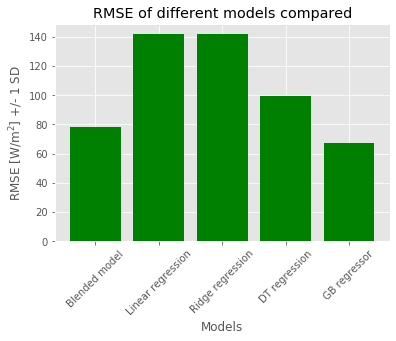

In [195]:
graph_results = {"Blended model":MSE_blending, 
                "Linear regression": MSE_lm,
                "Ridge regression": MSE_rrm,
                "DT regression": MSE_dtr,
                "GB regressor": MSE_gbr}

results_vals = [graph_results[k] for k in graph_results.keys()]
result_labels = [k for k in graph_results.keys()]



import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = result_labels
y = results_vals

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='green')
plt.xlabel("Models")
plt.ylabel(r"RMSE [W/m$^{2}$] +/- 1 SD")
plt.title("RMSE of different models compared")

plt.xticks(x_pos, x)
plt.xticks(rotation=45)

plt.show()